<a href="https://colab.research.google.com/github/nclskfm/DASP-documents/blob/main/evaluation_square_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Transformers installation
! pip install transformers datasets evaluate
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 15.2 MB/s 
     |████████████████████████████████| 441 kB 8.7 MB/s 
     |████████████████████████████████| 72 kB 1.3 MB/s 
     |████████████████████████████████| 163 kB 56.7 MB/s 
     |████████████████████████████████| 7.6 MB 52.9 MB/s 
     |████████████████████████████████| 212 kB 47.7 MB/s 
     |████████████████████████████████| 95 kB 5.1 MB/s 
     |████████████████████████████████| 115 kB 55.6 MB/s 
     |████████████████████████████████| 127 kB 69.1 MB/s 
     |████████████████████████████████| 115 kB 65.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


## Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_qa.py](https://github.com/huggingface/transformers/tree/main/examples/pytorch/question-answering/run_qa.py) and
[run_tf_squad.py](https://github.com/huggingface/transformers/tree/main/examples/tensorflow/question-answering/run_tf_squad.py)
scripts.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering")

context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/pytorch/question-answering/run_squad.py script.
"""

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = question_answerer(question="What is extractive question answering?", context=context)
print(
    f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}"
)

Answer: 'the task of extracting an answer from a text given a question', score: 0.6177, start: 34, end: 95


In [ ]:
result = question_answerer(question="What is a good example of a question answering dataset?", context=context)
print(
    f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}"
)

Answer: 'SQuAD dataset', score: 0.5152, start: 147, end: 160


Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators, token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering
import tensorflow as tf

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = TFAutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""

questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]

for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="tf")
    input_ids = inputs["input_ids"].numpy()[0]

    outputs = model(inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    # Get the most likely beginning of answer with the argmax of the score
    answer_start = tf.argmax(answer_start_scores, axis=1).numpy()[0]
    # Get the most likely end of answer with the argmax of the score
    answer_end = tf.argmax(answer_end_scores, axis=1).numpy()[0] + 1

    answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end])
    )

    print(f"Question: {question}")
    print(f"Answer: {answer}")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

All the layers of TFBertForQuestionAnswering were initialized from the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


Question: How many pretrained models are available in 🤗 Transformers?
Answer: over 32 +
Question: What does 🤗 Transformers provide?
Answer: general - purpose architectures
Question: 🤗 Transformers provides interoperability between which frameworks?
Answer: tensorflow 2. 0 and pytorch


# Evaluate
https://huggingface.co/docs/evaluate/v0.3.0/en/package_reference/evaluator_classes#evaluate.QuestionAnsweringEvaluator.compute.example 


In [ ]:
from evaluate import evaluator
from datasets import load_dataset
import pandas as pd

task_evaluator = evaluator("question-answering")

In [ ]:
data = load_dataset("squad_v2", split="validation[:500]")
results = task_evaluator.compute(
    model_or_pipeline="mrm8488/bert-tiny-finetuned-squadv2",
    data=data,
    metric="squad_v2",
    squad_v2_format=True,
)

results

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset squad_v2 downloaded and prepared to /root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d. Subsequent calls will reuse this data.


Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

{'exact': 50.8,
 'f1': 51.62373626373626,
 'total': 500,
 'HasAns_exact': 8.438818565400844,
 'HasAns_f1': 10.176658784253721,
 'HasAns_total': 237,
 'NoAns_exact': 88.97338403041825,
 'NoAns_f1': 88.97338403041825,
 'NoAns_total': 263,
 'best_exact': 52.6,
 'best_exact_thresh': 0.0,
 'best_f1': 52.62373626373625,
 'best_f1_thresh': 0.061676234006881714,
 'total_time_in_seconds': 4.827067690999996,
 'samples_per_second': 103.58255404875374,
 'latency_in_seconds': 0.009654135381999992}

This metric outputs a dictionary with 13 values:

- `'exact'`: Exact match (the normalized answer exactly match the gold answer) (see the exact_match metric (forthcoming))
- `'f1'`: The average F1-score of predicted tokens versus the gold answer (see the F1 score metric)
- `'total'`: Number of scores considered
- `'HasAns_exact'`: Exact match (the normalized answer exactly match the gold answer)
- `'HasAns_f1'`: The F-score of predicted tokens versus the gold answer
- `'HasAns_total'`: How many of the questions have answers
- `'NoAns_exact'`: Exact match (the normalized answer exactly match the gold answer)
- `'NoAns_f1'`: The F-score of predicted tokens versus the gold answer
- `'NoAns_total'`: How many of the questions have no answers
- `'best_exact'` : Best exact match (with varying threshold)
- `'best_exact_thresh'`: No-answer probability threshold associated to the best exact match
- `'best_f1'`: Best F1 score (with varying threshold)
- `'best_f1_thresh'`: No-answer probability threshold associated to the best F1

In [ ]:
data = load_dataset("squad_v2", split="validation")

models_to_evaluate = ['mrm8488/bert-tiny-finetuned-squadv2', 'deepset/roberta-base-squad2', 'ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA', 'mcsabai/huBert-fine-tuned-hungarian-squadv2']

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset squad_v2 downloaded and prepared to /root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d. Subsequent calls will reuse this data.


In [ ]:
def evaluate_model(model_id, data):
  return task_evaluator.compute(
      model_or_pipeline=model_id,
      data=data,
      metric="squad_v2",
      squad_v2_format=True,
  )

In [ ]:
def evaluate_models(models_to_evaluate, data):
  results = {}
  for model_id in models_to_evaluate:
    print(f'Start evaluation of model "{model_id}"')
    results[model_id] = evaluate_model(model_id, data)
    print(f'End evaluation of model "{model_id}"')
  return results

In [ ]:
%%time
results = evaluate_models(models_to_evaluate, data)

Start evaluation of model "mrm8488/bert-tiny-finetuned-squadv2"
End evaluation of model "mrm8488/bert-tiny-finetuned-squadv2"
Start evaluation of model "deepset/roberta-base-squad2"


Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/496M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

End evaluation of model "deepset/roberta-base-squad2"
Start evaluation of model "ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA"


Downloading:   0%|          | 0.00/851 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/538M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/761k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

End evaluation of model "ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA"
Start evaluation of model "mcsabai/huBert-fine-tuned-hungarian-squadv2"


Downloading:   0%|          | 0.00/675 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/382 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/272k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/776k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

End evaluation of model "mcsabai/huBert-fine-tuned-hungarian-squadv2"
CPU times: user 18min 26s, sys: 1min 10s, total: 19min 36s
Wall time: 20min 28s


In [ ]:
import json
results = json.loads('{"mrm8488/bert-tiny-finetuned-squadv2": {"exact": 48.70715067800893, "f1": 49.786948259084234, "total": 11873, "HasAns_exact": 9.379217273954117, "HasAns_f1": 11.541909021610476, "HasAns_total": 5928, "NoAns_exact": 87.92262405382675, "NoAns_f1": 87.92262405382675, "NoAns_total": 5945, "best_exact": 50.08001347595385, "best_exact_thresh": 0.007954456843435764, "best_f1": 50.0821190937421, "best_f1_thresh": 0.008744602091610432, "total_time_in_seconds": 57.96616471600001, "samples_per_second": 204.82638549869034, "latency_in_seconds": 0.004882183501726607}, "deepset/roberta-base-squad2": {"exact": 79.92082877116145, "f1": 82.9963457626089, "total": 11873, "HasAns_exact": 77.91835357624831, "HasAns_f1": 84.07820736158186, "HasAns_total": 5928, "NoAns_exact": 81.91757779646763, "NoAns_f1": 81.91757779646763, "NoAns_total": 5945, "best_exact": 79.92082877116145, "best_exact_thresh": 0.996823787689209, "best_f1": 82.99634576260925, "best_f1_thresh": 0.996823787689209, "total_time_in_seconds": 249.76654450600003, "samples_per_second": 47.53639052613302, "latency_in_seconds": 0.021036515160953426}, "ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA": {"exact": 12.2041607007496, "f1": 16.119351078283877, "total": 11873, "HasAns_exact": 24.426450742240217, "HasAns_f1": 32.26805926998389, "HasAns_total": 5928, "NoAns_exact": 0.01682085786375105, "NoAns_f1": 0.01682085786375105, "NoAns_total": 5945, "best_exact": 50.07159100480081, "best_exact_thresh": 0.0, "best_f1": 50.075334325313264, "best_f1_thresh": 0.000547960284166038, "total_time_in_seconds": 481.508082784, "samples_per_second": 24.657945368958877, "latency_in_seconds": 0.04055487937202055}, "mcsabai/huBert-fine-tuned-hungarian-squadv2": {"exact": 52.101406552682555, "f1": 53.47875752207112, "total": 11873, "HasAns_exact": 13.444669365721998, "HasAns_f1": 16.20332119762981, "HasAns_total": 5928, "NoAns_exact": 90.64760302775441, "NoAns_f1": 90.64760302775441, "NoAns_total": 5945, "best_exact": 52.109829023835594, "best_exact_thresh": 0.9827226996421814, "best_f1": 53.48717999322428, "best_f1_thresh": 0.9827226996421814, "total_time_in_seconds": 368.458089739, "samples_per_second": 32.223474882612365, "latency_in_seconds": 0.031033276319295883}}')

In [ ]:
results

{'mrm8488/bert-tiny-finetuned-squadv2': {'exact': 48.70715067800893,
  'f1': 49.786948259084234,
  'total': 11873,
  'HasAns_exact': 9.379217273954117,
  'HasAns_f1': 11.541909021610476,
  'HasAns_total': 5928,
  'NoAns_exact': 87.92262405382675,
  'NoAns_f1': 87.92262405382675,
  'NoAns_total': 5945,
  'best_exact': 50.08001347595385,
  'best_exact_thresh': 0.007954456843435764,
  'best_f1': 50.0821190937421,
  'best_f1_thresh': 0.008744602091610432,
  'total_time_in_seconds': 57.96616471600001,
  'samples_per_second': 204.82638549869034,
  'latency_in_seconds': 0.004882183501726607},
 'deepset/roberta-base-squad2': {'exact': 79.92082877116145,
  'f1': 82.9963457626089,
  'total': 11873,
  'HasAns_exact': 77.91835357624831,
  'HasAns_f1': 84.07820736158186,
  'HasAns_total': 5928,
  'NoAns_exact': 81.91757779646763,
  'NoAns_f1': 81.91757779646763,
  'NoAns_total': 5945,
  'best_exact': 79.92082877116145,
  'best_exact_thresh': 0.996823787689209,
  'best_f1': 82.99634576260925,
  'bes

In [ ]:
colors = ['red', 'blue', 'green', 'gray']

properties = list(results[models_to_evaluate[0]].keys())
properties

['exact',
 'f1',
 'total',
 'HasAns_exact',
 'HasAns_f1',
 'HasAns_total',
 'NoAns_exact',
 'NoAns_f1',
 'NoAns_total',
 'best_exact',
 'best_exact_thresh',
 'best_f1',
 'best_f1_thresh',
 'total_time_in_seconds',
 'samples_per_second',
 'latency_in_seconds']

In [ ]:
a = {}

for prop in properties:
  a[f'{prop}_x'] = []
  a[f'{prop}_y'] = []

  for model_id in models_to_evaluate:
    a[f'{prop}_x'].append(model_id)
    a[f'{prop}_y'].append(results[model_id][prop])

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

handles = [mpatches.Patch(color=colors[i], label=models_to_evaluate[i]) for i in range((len(colors)))]

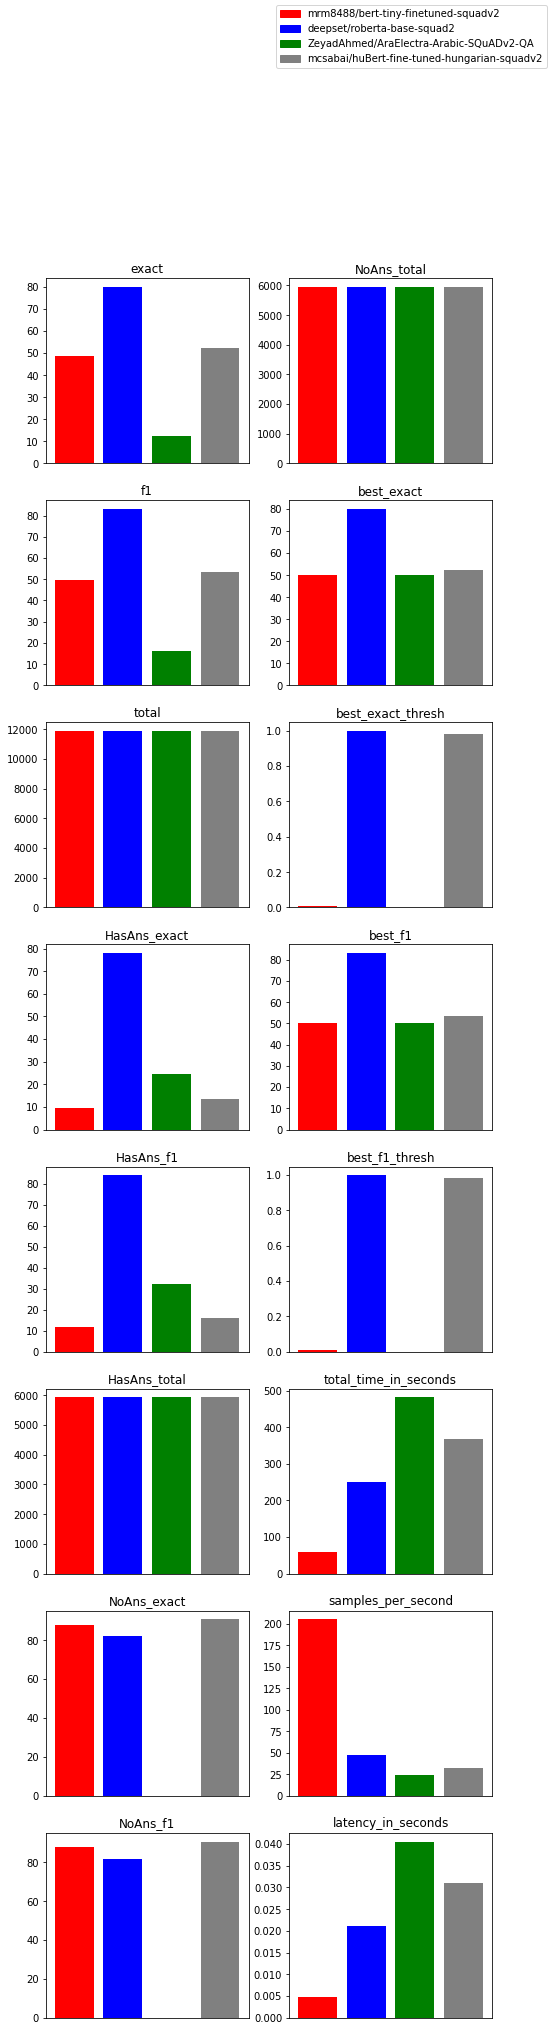

In [ ]:
nrows = len(properties) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(8,4*nrows))

for i in range(len(properties)):
  #print([i % len(properties)],[0 if i < nrows else 1])
  #print(properties[i])

  bars = axes[i % nrows][0 if i < nrows else 1].bar(a[f'{properties[i]}_x'], a[f'{properties[i]}_y'], color=colors)
  axes[i % nrows][0 if i < nrows else 1].set_title(properties[i])
  axes[i % nrows][0 if i < nrows else 1].get_xaxis().set_visible(False)

fig.legend(handles=handles)

fig.savefig('results.pdf')
